#quantum_classical_benchmarks

## Classical benchmarks

In [1]:
#!git clone https://github.com/leonardoLavagna/qaoa
#!pip install cvxpy
#!pip install -r requirements.txt

In [2]:
import pickle
import sys
import os
os.chdir("qaoa")

In [3]:
import networkx as nx
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from itertools import product

In [19]:
from qiskit import transpile
from qiskit_aer import Aer

In [10]:
from classes import Qaoa as Q
from classes import Problems as P
from functions import qaoa_utilities as qaoa_utils
from functions import qaoa_optimizers as optims
from config import *

In [5]:
graphs = []
for i in range(num_graphs):
    sys.path.append("classes/")
    path = "data/graph_"+str(i)+".nx"
    with open(path, 'rb') as f:
        g = pickle.load(f)
    graphs.append(g)

In [6]:
instance = graphs[1]
G = graphs[1].get_graph()

In [7]:
def brute_force(G):
    """
    Solves the Max-Cut problem using brute-force enumeration of all partitions.

    Parameters:
        G (networkx.Graph): An undirected graph.

    Returns:
        cut_value (int or float): The weight of the maximum cut.
        partition (tuple): A tuple of two sets representing the cut (S, V\S).
    """
    n = len(G.nodes)
    nodes = list(G.nodes)
    max_cut_value = -1
    best_partition = (set(), set())
    for bits in product([0, 1], repeat=n):
        S = {nodes[i] for i in range(n) if bits[i] == 0}
        T = set(nodes) - S
        cut_value = 0
        for u, v in G.edges:
            if (u in S and v in T) or (u in T and v in S):
                weight = G[u][v].get('weight', 1)
                cut_value += weight
        if cut_value > max_cut_value:
            max_cut_value = cut_value
            best_partition = (S, T)

    return max_cut_value, best_partition

In [8]:
def goemans_williamson(G, seed=None):
    """
    Solves the Max-Cut problem using the Goemans-Williamson approximation algorithm.

    Parameters:
        G (networkx.Graph): An undirected graph.
        seed (int): Random seed for reproducibility.

    Returns:
        cut_value (float): The value of the cut found.
        partition (tuple): A tuple of two sets (S, V\S) representing the cut.
    """
    if seed is not None:
        np.random.seed(seed)

    n = len(G.nodes)
    W = nx.to_numpy_array(G)
    # Define the SDP
    X = cp.Variable((n, n), PSD=True)
    objective = cp.Maximize(0.25 * cp.sum(cp.multiply(W, 1 - X)))
    constraints = [cp.diag(X) == 1]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    # Cholesky decomposition and rounding
    X_opt = X.value
    try:
        # numerical stability
        L = np.linalg.cholesky(X_opt + 1e-8 * np.eye(n))
    except np.linalg.LinAlgError:
        # fallback if not PSD
        L = np.linalg.svd(X_opt)[0]
    r = np.random.normal(size=n)
    r = r / np.linalg.norm(r)
    signs = np.sign(L @ r)
    S = {i for i in range(n) if signs[i] >= 0}
    cut_value = sum(W[i, j] for i in S for j in range(n) if j not in S)
    return cut_value, (S, set(range(n)) - S)

Max-Cut value (brute force): 9
True Partition: {0, 1, 2} {3, 4, 5}


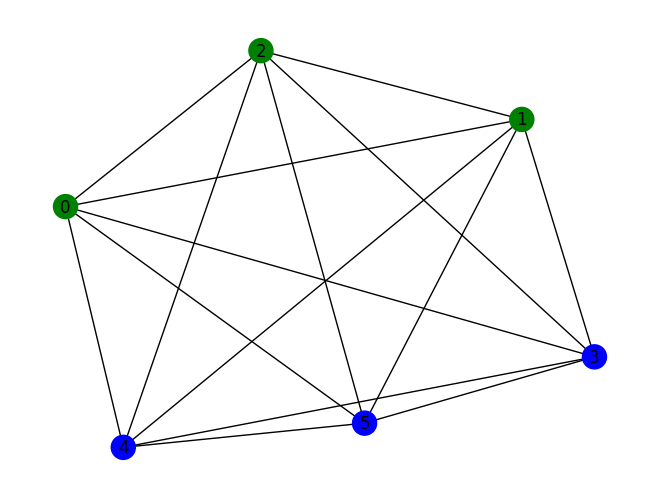

Classical approximation of the cut value: 9.0
Approximate Partition: {0, 1, 3} {2, 4, 5}


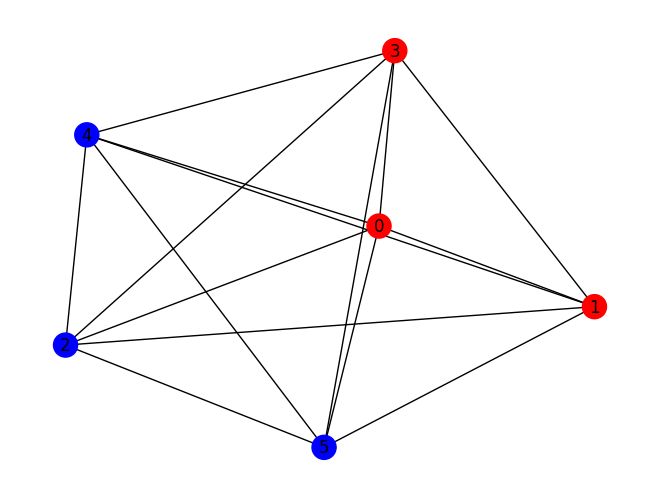

Classical approximation ratio 1.0


In [9]:
cut_value, (S, T) = goemans_williamson(G, seed=42)
true_cut_value, (S_true, T_true) = brute_force(G)
print("Max-Cut value (brute force):", true_cut_value)
print("True Partition:", S_true, T_true)
color_map_true = ['green' if node in S_true else 'blue' for node in G.nodes]
nx.draw(G, node_color=color_map_true, with_labels=True)
plt.show()
print("Classical approximation of the cut value:", cut_value)
print("Approximate Partition:", S, T)
color_map = ['red' if node in S else 'blue' for node in G.nodes]
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()
print("Classical approximation ratio", cut_value/true_cut_value)

## Quantum benchmarks

In [21]:
def get_partitions_from_solution(G, solution):
    partition_1 = [node for node, bit in enumerate(solution) if bit == '0']
    partition_2 = [node for node, bit in enumerate(solution) if bit == '1']
    return partition_1, partition_2

In [22]:
betas = qaoa_utils.generate_parameters(n=p, k=1, seed=seed)
gammas = qaoa_utils.generate_parameters(n=p, k=2, seed=seed)
qaoa = Q.Qaoa(p=p, G=instance, betas=betas, gammas=gammas, mixer=mixer, seed=seed, verbose=verbose)
_, f = optims.simple_optimization(qaoa, method=method, seed=seed, shots=shots, verbose=verbose)

In [23]:
qc = qaoa.get_circuit()
init_point = list(betas) + list(gammas)
qc = qc.assign_parameters(init_point)
backend = Aer.get_backend("aer_simulator")
t_qc = transpile(qc, backend=backend)
job = backend.run(t_qc)
counts = job.result().get_counts(qc)
most_frequent_solution = max(counts, key=counts.get)
G = nx.Graph(qaoa.G.get_graph())
S_q, T_q = get_partitions_from_solution(G, most_frequent_solution)

Max-Cut value (brute force): 9
True Partition: {0, 1, 2} {3, 4, 5}


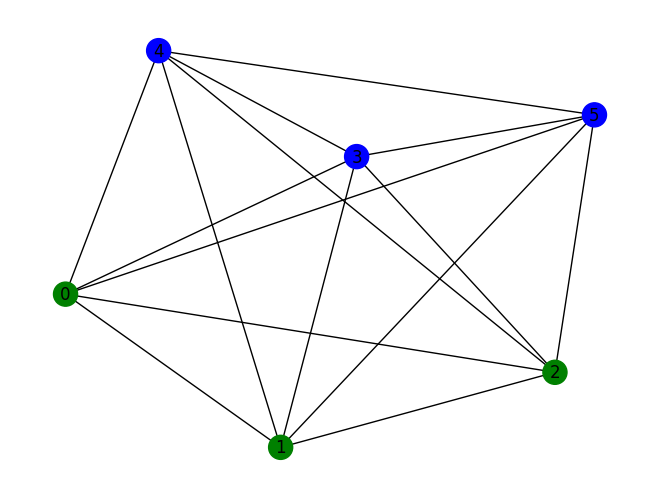

QAOA approximation of the cut value: 9
Approximate Partition: [2] [0, 1, 3, 4, 5]


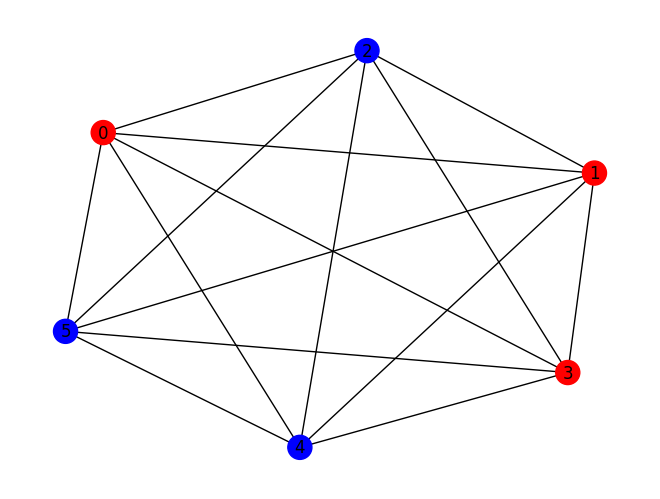

QAOA approximation ratio 0.9741753472222222


In [24]:
print("Max-Cut value (brute force):", true_cut_value)
print("True Partition:", S_true, T_true)
color_map_true = ['green' if node in S_true else 'blue' for node in G.nodes]
nx.draw(G, node_color=color_map_true, with_labels=True)
plt.show()
print("QAOA approximation of the cut value:", true_cut_value)
print("Approximate Partition:", S_q, T_q)
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()
print("QAOA approximation ratio", -f/true_cut_value)